# Forecasting
______________________________________________________

### Import Relevant Packages

In [1]:
# Package Importation
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from datetime import date, timedelta
import requests
import bs4 as bs
import pickle
from os import listdir
from os import environ
import quandl
from math import floor

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# GPU Utilization
from tensorflow.python.client import device_lib
#environ["CUDA_VISIBLE_DEVICES"] = "-1" # Toggles GPU utilization
print("GPUs: ", device_lib.list_local_devices(), "\n")

'''
# Input functions from other notebook
import import_ipynb
from functions_1 import *
'''

# Import API keys
from API_keys import Quandl_api_key, AlphaVantage_api_key

# Check versions
print('python: {}'.format(sys.version))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('pandas_datareader: {}'.format(pdr.__version__))
print('requests: {}'.format(requests.__version__))
print('bs4: {}'.format(bs.__version__))
#print('tensorflow: {}'.format(tf.version.VERSION))
#print('tensorflow: {}'.format(tf.__version__))

%matplotlib inline

# Quandl API Configuration
quandl.ApiConfig.api_key = Quandl_api_key

GPUs:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 61500743351812964
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1451678105
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12020832296672832270
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:02:00.0, compute capability: 5.0"
] 

python: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
pandas: 0.25.1
numpy: 1.16.5
pandas_datareader: 0.8.1
requests: 2.22.0
bs4: 4.8.0


### Functions to Import Ticker and S&P 500 Price/ Volume Data

In [2]:
# Pull Tickers
def sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.rstrip('\n'))
        
    with open("Forecasting_Exp_1_Data\sp500_tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

def sp500_yahoo(tickers, start, end):
    yahoo_df = pd.DataFrame()
    date_string = '_from_' + str(start) + '_to_' + str(end)

    for i, ticker in enumerate(tickers):
        print("Collecting Yahoo data ", str(i+1), " of ", str(len(tickers)), ": ", ticker)
        try:
            ticker_data = pdr.get_data_yahoo(symbols=ticker, start=start, end=end)
            ticker_data['Ticker'] = ticker
            ticker_data.reset_index(inplace=True,drop=False)
            yahoo_df = yahoo_df.append(ticker_data)

        except:
            print("Exception")
            continue
            
    pickle_save_path = 'Forecasting_Exp_1_Data\sp500_yahoo' + date_string + '.pickle'
    with open(pickle_save_path,"wb") as f:
        pickle.dump(yahoo_df,f)
        
    excel_save_path = 'Forecasting_Exp_1_Data\sp500_yahoo' + date_string + '.xlsx'
    yahoo_df.to_excel(excel_save_path)

    return yahoo_df


###  Functions to Import Quandl Data

In [3]:
def get_sentiment(start, end):
    date_string = '_from_' + str(start) + '_to_' + str(end)

    sent_df = pd.DataFrame(quandl.get('AAII/AAII_SENTIMENT', start_date=start, end_date=end))
    sent_df.reset_index(inplace=True,drop=False)

    pickle_save_path = 'Forecasting_Exp_1_Data\sentiment' + date_string + '.pickle'
    with open(pickle_save_path,"wb") as f:
        pickle.dump(sent_df,f)
        
    excel_save_path = 'Forecasting_Exp_1_Data\sentiment' + date_string + '.xlsx'
    sent_df.to_excel(excel_save_path)
    return quandl.get('AAII/AAII_SENTIMENT', start_date=start, end_date=end)


### Functions to Update Data Dictionary (Local Datasets)

In [7]:
# Update local datasets
def update_data(start, end, overwrite_all = 0):
    '''
    Input: Dictionary of All Datasets
    Returns: Updated Data, or saved data
    '''
    date_string = '_from_' + str(start) + '_to_' + str(end)

    stored_files = listdir('Forecasting_Exp_1_Data')
    print("Stored files: ", stored_files)
    
    data_dict = {}
    
    # Add sp500 tickers
    if ('sp500_tickers.pickle' in stored_files) and (overwrite_all == 0):
        print('Loading Tickers from file')
        with open('Forecasting_Exp_1_Data\sp500_tickers.pickle', 'rb') as f:
            data_dict['sp500_tickers'] = pickle.load(f)
    else:
        print('Pulling Tickers from web')
        data_dict['sp500_tickers'] = sp500_tickers()

    # Add yahoo data
    pickle_yahoo_path = "sp500_yahoo" + date_string + ".pickle"
    pickle_yahoo_dir_path = "Forecasting_Exp_1_Data\sp500_yahoo" + date_string + ".pickle"
    if (pickle_yahoo_path in stored_files) and (overwrite_all == 0):
        print('Loading Yahoo price data from file')
        with open(pickle_yahoo_dir_path, 'rb') as f:
            data_dict['sp500_yahoo'] = pickle.load(f)
    else:
        print('Pulling Yahoo price data from web')
        data_dict['sp500_yahoo'] = sp500_yahoo(data_dict['sp500_tickers'], start, end)
        # data_dict['sp500_yahoo'] = sp500_yahoo(data_dict['sp500_tickers'].append('^GSPC'), start, end)

    # Add sentiment Data
    pickle_sent_path = "sentiment" + date_string + ".pickle"
    pickle_sent_dir_path = "Forecasting_Exp_1_Data\sentiment" + date_string + ".pickle"
    if (pickle_sent_path in stored_files) and (overwrite_all == 0):
        print('Loading sentiment data from file')
        with open(pickle_sent_dir_path, 'rb') as f:
            data_dict['sentiment'] = pickle.load(f)
    else:
        print('Pulling sentiment data from web')
        data_dict['sentiment'] = get_sentiment(start, end)
        
    return data_dict

### Helper Functions

In [74]:
def splitter_folds(df_series, train_percent, num_folds):
    
    """
    Input: df_series as [type] pandas.core.series.Series
    Input: train_percent as [type] float
    Returns: tuple of fold lists, train lists and test lists
    """
    
    series_length = len(df_series)
    splits = np.linspace(0, series_length, num_folds + 1, endpoint = True, dtype=int)
        
    train_list = []
    test_list = []
    fold_list = []
    
    for index, value in enumerate(splits):
        if index == 0:
            continue
        
        fold = df_series[splits[index-1]:splits[index]]
        fold_list.append(fold)
        fold_len = len(fold)
        train_list.append(fold[:floor(train_percent*fold_len)])
        test_list.append(fold[floor(train_percent*fold_len):])
    
    return(fold_list, train_list, test_list)

def splitter(df, train_percent):
    
    df_length = df.shape[0]
    split_index = floor(train_percent * df_length)
    
    df_train = pd.DataFrame(df[0:split_index])
    df_test = pd.DataFrame(df[split_index:])
    
    
    return (df_train, df_test)
    
def smoother_scaler(train_data, test_data, EMA, gamma):
    
    """
    train_data: [type: pandas DataFrame]
    """
    train_data_sm_sc = pd.DataFrame()
    test_data_sm_sc = pd.DataFrame()
    
    for col in train_data.columns:
        scaler = MinMaxScaler()
                    
        train_col = np.asarray(scaler.fit_transform(np.asarray(train_data[col]).reshape(-1, 1)))
        test_col = np.asarray(scaler.transform(np.asarray(test_data[col]).reshape(-1, 1)))
                
        for i in range(len(train_col)):
                    EMA = gamma*train_col[i] + (1-gamma)*EMA
                    train_col[i] = EMA
                
        for j in range(len(test_col)):
                    EMA = gamma*test_col[j] + (1-gamma)*EMA
                    test_col[j] = EMA
                    
        train_col = train_col.reshape(-1)
        test_col = test_col.reshape(-1)
                    
        train_data_sm_sc[col] = train_col
        test_data_sm_sc[col] = test_col
     
    return (train_data_sm_sc, test_data_sm_sc)


def ltsm_sequence_generator(train_data, seq_length):
    
    train_data = np.asarray(train_data)
    
    X_train = []
    y_train = []
    for i in range(seq_length, train_data.shape[0]):
        X_train.append(train_data[i-seq_length:i])
        y_train.append(train_data[i, 0])
        
    return (np.asarray(X_train), np.asarray(y_train))

### Neural Network Construction

In [59]:
def build_NN(train_data, batch_size, dropout):

    '''
    Define Model
    '''
    
    regressior = Sequential()
    
    regressior.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (train_data.shape[1], train_data.shape[2])))
    regressior.add(Dropout(dropout))
    
    regressior.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
    regressior.add(Dropout(1.5*dropout))
    
    regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
    regressior.add(Dropout(2*dropout))
    
    regressior.add(LSTM(units = 120, activation = 'relu'))
    regressior.add(Dropout(2.5*dropout))
    
    regressior.add(Dense(units=1))
    
    regressior.summary()
    
    return regressior

def add_Optimizer(model):

    '''
    Optimizer
    '''
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    
    return model

def train_Model(model, X_train, y_train, epochs, batch_size):

    '''
    Train
    '''
    print(X_train.shape, y_train.shape, epochs, batch_size)
    
    model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
    
    return model

def evalulate_performance(model, train_data, test_data, seq_length):
    
    past_x_days = train_data.tail(seq_length)
    df = past_x_days.append(data_test, ignore_index = True)
    df = df.drop(['Date', 'Adj Close'], axis = 1)
    
    scaler = MinMaxScaler()
    
    inputs = scaler.transform(df)

    X_test = []
    y_test = []
    
    for i in range(seq_length, inputs.shape[0]):
        X_test.append(inputs[i-seq_length:i])
        y_test.apend(inputs[i, 0])
        
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test.shape, y_test.shape
    y_pred = model.predict(X_test)

    scaler.scale_

    return


### Commands to Collect Data

In [81]:
# Date information
today = date.today()
year_ago = today - timedelta(days=365)

# Pull Stock Data
print("Pulling data from ", year_ago, " to ", today)

data_dict = update_data(start=year_ago, end=today, overwrite_all = 0)


Pulling data from  2018-12-17  to  2019-12-17
Stored files:  ['sentiment_from_2018-12-14_to_2019-12-14.pickle', 'sentiment_from_2018-12-14_to_2019-12-14.xlsx', 'sentiment_from_2018-12-15_to_2019-12-15.pickle', 'sentiment_from_2018-12-15_to_2019-12-15.xlsx', 'sentiment_from_2018-12-16_to_2019-12-16.pickle', 'sentiment_from_2018-12-16_to_2019-12-16.xlsx', 'sentiment_from_2018-12-17_to_2019-12-17.pickle', 'sentiment_from_2018-12-17_to_2019-12-17.xlsx', 'sp500_tickers.pickle', 'sp500_yahoo_from_2018-12-14_to_2019-12-14.pickle', 'sp500_yahoo_from_2018-12-14_to_2019-12-14.xlsx', 'sp500_yahoo_from_2018-12-15_to_2019-12-15.pickle', 'sp500_yahoo_from_2018-12-15_to_2019-12-15.xlsx', 'sp500_yahoo_from_2018-12-16_to_2019-12-16.pickle', 'sp500_yahoo_from_2018-12-16_to_2019-12-16.xlsx', 'sp500_yahoo_from_2018-12-17_to_2019-12-17.pickle', 'sp500_yahoo_from_2018-12-17_to_2019-12-17.xlsx']
Loading Tickers from file
Loading Yahoo price data from file
Loading sentiment data from file


### Visualization

In [82]:
AAL_df = data_dict["sp500_yahoo"].loc[data_dict["sp500_yahoo"]['Ticker'] == 'AAL']
AAL_df.reset_index(inplace=True,drop=False)

print(AAL_df.head())

sent_df = data_dict["sentiment"]
sent_df.reset_index(inplace=True,drop=False)

   index       Date       High        Low       Open      Close      Volume  \
0      0 2018-12-17  32.860001  31.700001  32.299999  32.040001   7638100.0   
1      1 2018-12-18  33.650002  32.470001  32.470001  33.540001   9117600.0   
2      2 2018-12-19  33.980000  32.230000  33.459999  32.419998   8120500.0   
3      3 2018-12-20  32.680000  30.950001  32.340000  31.889999   9439600.0   
4      4 2018-12-21  32.650002  30.650000  31.950001  30.780001  11800600.0   

   Adj Close Ticker  
0  31.646681    AAL  
1  33.128265    AAL  
2  32.022011    AAL  
3  31.498520    AAL  
4  30.402149    AAL  


<Figure size 432x288 with 0 Axes>

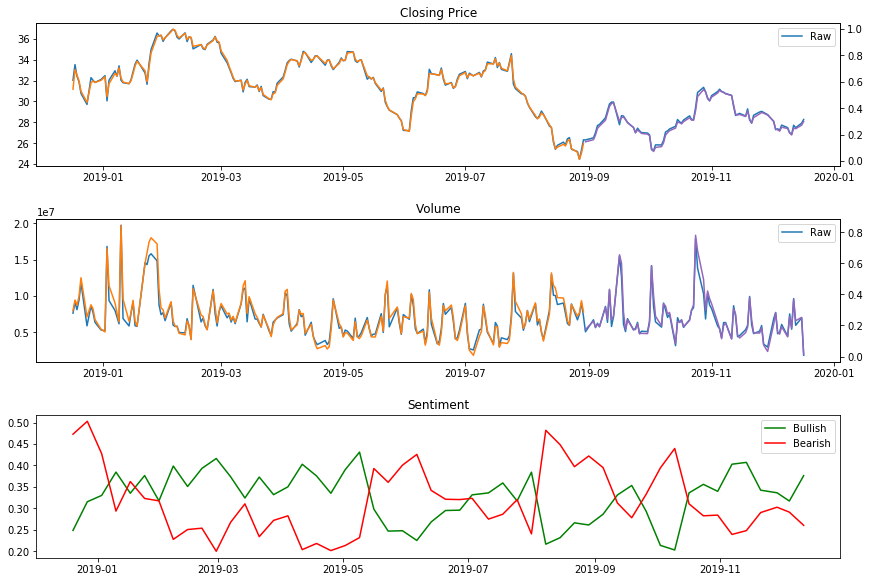

In [98]:

'''
Hyperparameter Definition
'''
EMA = 0.0
gamma = 0.8
''''''

AAL_df_train, AAL_df_test = splitter(AAL_df, 0.7)

AAL_df_train_text = pd.DataFrame({'Date': AAL_df_train['Date'], 'Ticker': AAL_df_train['Ticker']})
AAL_df_train = AAL_df_train.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)

AAL_df_test_text = pd.DataFrame({'Date': AAL_df_test['Date'], 'Ticker': AAL_df_test['Ticker']})

AAL_df_test = AAL_df_test.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)

AAL_df_train_sm_sc, AAL_df_test_sm_sc = smoother_scaler(AAL_df_train, AAL_df_test, EMA, gamma)


for col in AAL_df_train_text.columns:
    AAL_df_train_sm_sc[col] = AAL_df_train_text[col].values
    
for col in AAL_df_test_text.columns:
    AAL_df_test_sm_sc[col] = AAL_df_test_text[col].values

plt.figure(1)
fig, axs = plt.subplots(3, 1, figsize=(12,8))

axs[0].plot(AAL_df['Date'], AAL_df['Close'], label = "Raw", c = 'tab:blue')
axs01 = axs[0].twinx()  
axs01.plot(AAL_df_train_sm_sc['Date'], AAL_df_train_sm_sc['Close'], label = "Smoothed", c = 'tab:orange')
axs01.plot(AAL_df_test_sm_sc['Date'], AAL_df_test_sm_sc['Close'], label = "Smoothed", c = 'tab:purple')

axs[1].plot(AAL_df['Date'], AAL_df['Volume'], label = "Raw", c = 'tab:blue')
axs11 = axs[1].twinx()
axs11.plot(AAL_df_train_sm_sc['Date'], AAL_df_train_sm_sc['Volume'], label = "Smoothed", c = 'tab:orange')
axs11.plot(AAL_df_test_sm_sc['Date'], AAL_df_test_sm_sc['Volume'], label = "Smoothed", c = 'tab:purple')

axs[2].plot(sent_df['Date'], sent_df['Bullish'], label = "Bullish", color='g')
axs[2].plot(sent_df['Date'], sent_df['Bearish'], label = "Bearish", color='r')

axs[0].set_title("Closing Price")
axs[1].set_title("Volume")
axs[2].set_title("Sentiment")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

axs[0].legend()
axs[1].legend()
axs[2].legend()



### Commands to Run NN

In [15]:
'''
Format Data to Feed to NN
'''
data_training = data_training.drop(['Date', 'Adj Close'], axis = 1)


#data_training = data_training.drop(['Date', 'Adj Close'], axis = 1)
data_training = {'Open':AAL_open, 
                 'Close':AAL_close, 
                 'Volume':AAL_vol, 
                 'High':AAL_high, 
                 'Low':AAL_low, 
                }


'''
NEED TO FIRST NORMALIZE AND SMOOTH THE DATA
'''

data_training = pd.DataFrame(data_training) 



X_train, y_train = ltsm_sequence_generator(data_training, 60)


'''
Hyperparameter Definition
'''

#D = 1 # Input dimensionality
#num_unrollings = 50 # How many continuous time steps you consider for a single optimization step. The larger the better.
batch_size = 10 # Standard batch size
#num_nodes = [200,200,150] # Represents the number of hidden neurons in each layer (number of layer is number of numbers)
#n_layers = len(num_nodes)
dropout = 0.2
epochs = 10

''''''


model = build_NN(X_train, batch_size, dropout)
model = add_Optimizer(model)
model = train_Model(model, X_train, y_train, epochs, batch_size)
evalulate_performance(model, train_data, test_data, seq_length)

'''
Testing
'''

[32.27999878 31.5        31.5        31.5        30.88999939 31.31999969
 30.53000069 30.51000023 30.27000046 31.01000023 31.13999939 31.97999954
 33.04000092 33.22000122 33.95999908 33.97000122 33.63999939 33.36999893
 33.75999832 33.99000168 34.99000168 34.65000153 33.95999908 34.45000076
 34.43000031 34.09999847 33.43000031 33.91999817 34.04999924 32.15000153
 33.50999832 33.77999878 34.29999924 33.95999908 34.20999908 34.25
 34.25       33.70000076 33.38999939 33.72000122 33.15999985 32.18999863
 32.02999878 32.20000076 32.02999878 30.64999962 31.20999908 31.22999954
 29.72999954 29.69000053 29.26000023 28.51000023 28.5        27.79999924
 27.12000084 27.62999916 29.76000023 30.39999962 30.59000015 31.14999962
 31.10000038 30.55999947 31.69000053 32.97000122 32.09999847 32.77999878
 32.72000122 33.65999985 32.02999878 31.56999969 31.82999992 31.47999954
 31.55999947 32.22999954 33.13999939 33.09000015 32.40000153 32.54000092
 31.98999977 32.40000153 32.93000031 33.06000137 33.11999

KeyboardInterrupt: 